<a href="https://colab.research.google.com/github/Smoulvad01/AI-C1-image-/blob/main/Inspecting_image_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='green'>Import and Path</font>

In [1]:
import cv2
from PIL import Image # To display images
from sklearn.decomposition import NMF, PCA
from collections import Counter

# TensorFlow and tf.keras
import tensorflow as tf
from keras.utils.vis_utils import plot_model

# Helper libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from importlib import reload
from collections import Counter
from PIL import Image
import os

reload(plt)
np.set_printoptions(suppress=True)
print(tf.__version__)


2.12.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
directory_train = "/content/drive/MyDrive/AI and ML /dataset_new-2/train"
directory_test = "/content/drive/MyDrive/AI and ML /dataset_new-2/test"

# <font color='green'>Inspect Data Before Processing </font>

### Check Image Sizes

In [6]:
# check for smallest and largest image 
from PIL import Image
import os

# Initialize variables to hold the smallest and largest images
smallest_image = None
largest_image = None

smallest_image_size = float('inf')  # set initial smallest size to infinity
largest_image_size = float('-inf')  # set initial largest size to negative infinity

# Iterate over all images in the specified directory
for filename in os.listdir(directory_train+"/Open/"):
    #if filename.endswith(".jpg") or filename.endswith(".png"):  # add more file types if needed
    img = Image.open(os.path.join(directory_train+"/Open/", filename))
    width, height = img.size
    image_size = width * height  # total pixel count
    #print("Debug: Image size: " + str(image_size))
    # Check if current image is the smallest one
    if image_size < smallest_image_size:
        smallest_image_size = image_size
        smallest_image = img

    # Check if current image is the largest one
    if image_size > largest_image_size:
        largest_image_size = image_size
        largest_image = img

print("Largest image size: " + str(largest_image_size))
print("Smallest image size: " + str(smallest_image_size))
# Now smallest_image and largest_image hold the smallest and largest images respectively.

Largest image size: 2293710
Smallest image size: 2250


### Statistics on Dataset Images 

In [10]:

import os
from PIL import Image
import numpy as np


def image_sizes(directory):
    sizes = []
    for filename in os.listdir(directory):
        img = Image.open(os.path.join(directory, filename))
        width, height = img.size
        sizes.append(width * height)
    return sizes

# Calculate sizes
sizes_train_open = image_sizes(directory_train+"/Open/")
sizes_train_closed = image_sizes(directory_train+"/Closed/")
sizes_test_open = image_sizes(directory_test+"/Open/")
sizes_test_closed = image_sizes(directory_test+"/Closed/")

# Calculate statistics
def calculate_statistics(sizes):
    return {
        'mean': np.mean(sizes),
        'median': np.median(sizes),
        'min': np.min(sizes),
        'max': np.max(sizes),
        'std': np.std(sizes),
    }

# Print statistics
for name, sizes in [('Train/Open', sizes_train_open), 
                    ('Train/Closed', sizes_train_closed), 
                    ('Test/Open', sizes_test_open), 
                    ('Test/Closed', sizes_test_closed)]:
    stats = calculate_statistics(sizes)
    print(f"Image size statistics in {name}: ")
    for stat, value in stats.items():
        print(f"  {stat}: {value}")


def image_sizes(directory):
    sizes = []
    for filename in os.listdir(directory):
        img = Image.open(os.path.join(directory, filename))
        width, height = img.size
        sizes.append(width * height)
    return sizes

# Get directories
directories = [directory_train+"/Open/", directory_train+"/Closed/",
               directory_test+"/Open/", directory_test+"/Closed/"]

# Calculate sizes for all directories
sizes_all = []
for directory in directories:
    sizes_all.extend(image_sizes(directory))

# Calculate statistics
def calculate_statistics(sizes):
    return {
        'mean': np.mean(sizes),
        'median': np.median(sizes),
        'min': np.min(sizes),
        'max': np.max(sizes),
        'std': np.std(sizes),
    }

# Print statistics
stats = calculate_statistics(sizes_all)
print(f"Image size statistics for the aggregate dataset: ")
for stat, value in stats.items():
    print(f"  {stat}: {value}")


Image size statistics in Train/Open: 
  mean: 142565.2414910859
  median: 96900.0
  min: 2250
  max: 2293710
  std: 206027.72118035448
Image size statistics in Train/Closed: 
  mean: 169454.55591572123
  median: 92700.0
  min: 4158
  max: 2640625
  std: 305579.49696381553
Image size statistics in Test/Open: 
  mean: 146018.79816513762
  median: 95100.0
  min: 3960
  max: 1638400
  std: 215512.52309630506
Image size statistics in Test/Closed: 
  mean: 163292.22018348624
  median: 91800.0
  min: 4928
  max: 1638400
  std: 273434.65731457766
Image size statistics for the aggregate dataset: 
  mean: 155806.55371900825
  median: 94200.0
  min: 2250
  max: 2640625
  std: 258807.10081300576


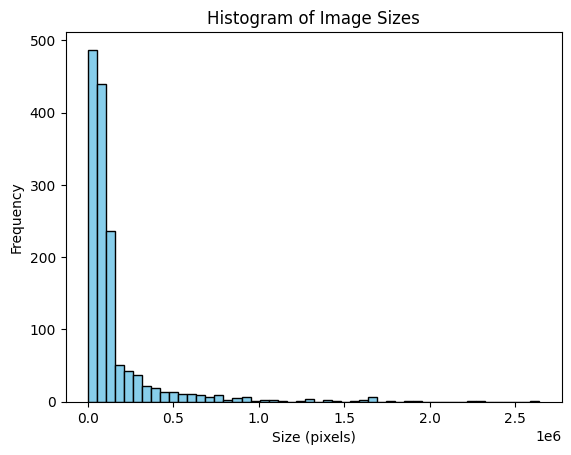

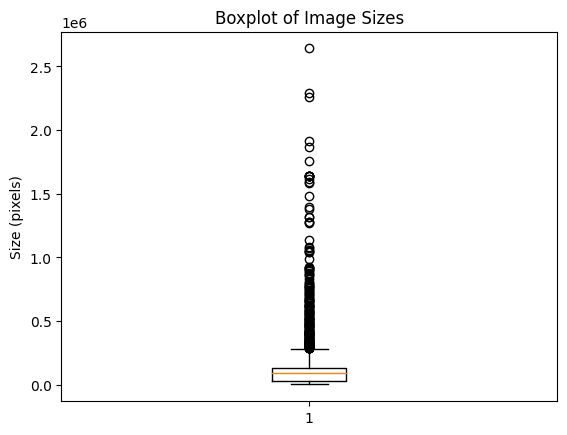

In [13]:
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(sizes_all, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Image Sizes")
plt.xlabel("Size (pixels)")
plt.ylabel("Frequency")

# Show the plot
plt.show()


# Create a boxplot
plt.boxplot(sizes_all)
plt.title("Boxplot of Image Sizes")
plt.ylabel("Size (pixels)")

# Show the plot
plt.show()

### Visually Inspect Images 

Original Image: _586.jpg


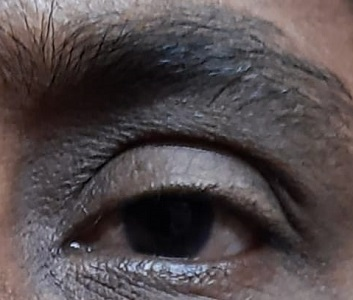

Original Image: _434.jpg


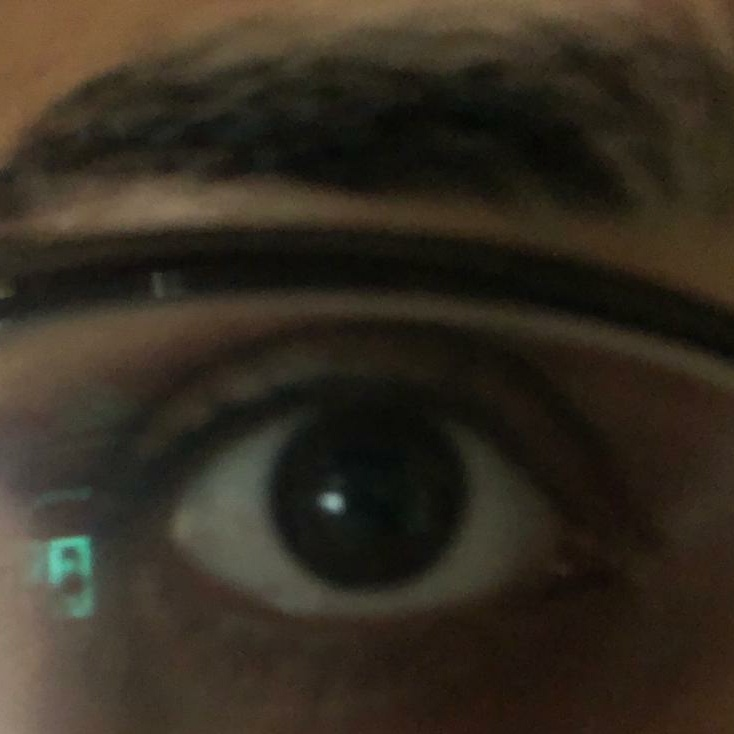

Original Image: _72.jpg


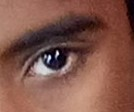

In [11]:
# Visually inspect random images to get to know dataset and compare to processed data later
folder_path = "/content/drive/MyDrive/AI and ML /dataset_new-2/test/Open/" 

image_list = os.listdir(folder_path)
random.shuffle(image_list)


for i in range(3):
    if i < len(image_list):
        image_path = os.path.join(folder_path, image_list[i])
        test_img = cv2.imread(image_path)
        print("Original Image:", image_list[i])
        imageRGB = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        print_original_image = Image.fromarray(imageRGB)
        print_original_image.show()
    else:
        break

# <font color='green'>Inspect Data After Processing</font>

### Load and Process Data using Keras

In [ ]:
def load_image_dataset(directory):
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        class_names=None,
        color_mode='grayscale',
        batch_size=32,
        image_size=(256, 256),
        shuffle=True,
        seed=42,
        validation_split=False,
        interpolation='mitchellcubic',
        follow_links=False,
        crop_to_aspect_ratio=False,
    )
    return dataset

In [ ]:
#Define train_images and test_images
train_images = load_image_dataset(directory_train)
test_images = load_image_dataset(directory_test)

In [ ]:
#Labeling to give classnames 
class_names = train_images.class_names
print(class_names)

In [ ]:
#Checking the train test split ratio 
train_size = 1234
test_size = 218

print(test_size/(train_size+test_size))

### Inspect Image Labels

In [ ]:
# get the count of elements in the batched datasets
# For training data
train_class_counts = Counter()

for images, labels in train_images:
    train_class_counts.update(labels.numpy())

print("Training data class counts:", train_class_counts)

# For testing data
test_class_counts = Counter()

for images, labels in test_images:
    test_class_counts.update(labels.numpy())

print("Testing data class counts:", test_class_counts)

### Visualize the Images

In [ ]:
# plotting to inspect images visually and check correct labelling 
plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):
  for i in range(12):
    ax = plt.subplot(3,4 , i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.grid(True)

### Inspect Batches

In [ ]:
# get the count of batches
batch_count = tf.data.experimental.cardinality(train_images).numpy()
print("Number of batches: " + str(batch_count))

In [ ]:
# inspect the batches
for images, labels in train_images.take(1):
    print(images.shape) #(1) denotes the number of images in the batch. (2) denotes the height and width of each image in pixels.(4) denotes the number of color channels in each image, which is typically RGB (red, green, blue) or grayscale.
    print(images.dtype)
    print(labels.shape)
    print(labels.dtype)

In [ ]:
# check if all images are the same size in the batches
def check_image_sizes(dataset):
    for images, labels in dataset.take(1):
        for i in range(len(images)):
            print(f"Image {i+1} size: {images[i].shape}")

# Check sizes of train images
print("Train images sizes:")
check_image_sizes(train_images)

# Check sizes of test images
print("Test images sizes:")
check_image_sizes(test_images)

### Check For Corrupted Images

In [ ]:
def get_all_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):  # Add/modify file extensions to suit your dataset
                image_paths.append(os.path.join(root, file))
    return image_paths

corrupted_images = []

# Obtain all image paths from training and testing directories
all_image_paths = get_all_image_paths(file_path_folder_train) + get_all_image_paths(file_path_folder_test)

for img_path in all_image_paths:
    try:
        img = Image.open(img_path)
        img.verify()  # This will raise an exception if the image is not valid
    except (IOError, SyntaxError) as e:
        corrupted_images.append(img_path)

print(f"Number of corrupted images: {len(corrupted_images)}")